In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

ROWS = 6
COLUMNS = 9
GAMMA = 0.95
ALPHA = 0.1
#STEP = 1000
EPISODES = 50
EXPERIMENTS = 30

In [2]:
class GridWorld():
    
    def __init__(self, rows, columns):
        self.rows = rows
        self.columns = columns
        self.grid = {}
        self.state = 18
    
    def reset(self):
        self.state = 18
        return self.state
    
    def set_reward(self, info):
        for i in xrange(self.rows * self.columns):
            self.grid[i] = [-1, 0, 1]
                          
        for state, reward, done, legal in info:
            self.grid[state] = [reward, done, legal]
    
        
    def step(self, action):
        #  up: 0
        #down: 1
        #left: 2
        #right: 3
        state = self.state
        
        if action == 0 and self.state >= self.columns:
            self.state -= 9
        if action == 1 and self.state < self.columns*(self.rows-1):
            self.state += 9
        if action == 2 and self.state % self.columns != 0:
            self.state -= 1
        if action == 3 and self.state % self.columns != self.columns-1:
            self.state += 1
        if not self.grid[self.state][2]:
            self.state = state
            
        return self.state, self.grid[state][0], self.grid[state][1] 

In [3]:
class Agent():
    def __init__(self, rows, columns, info):
        self.Q_values = np.zeros((rows * columns, 4))
        self.epsilon = 0.1
        self.actions = [0,1,2,3]
        self.model = []
        for i in xrange(len(info)):
            self.Q_values[info[i][0], :] = 0
    def choose_eps_greedy(self, state, step):
        rand = random.random()
        #self.epsilon /= 1. * np.sqrt(step)/2 
        if rand < self.epsilon:
            return random.choice(self.actions)
        else:
            return np.argmax(self.Q_values[state, :])

In [4]:
def smoothing(result, batch):
    new_result = []
    for i in xrange(len(result)/batch):
        average = 1.*sum(result[batch * i: batch * i+batch])/batch
        new_result.append(average)
    return new_result

In [5]:
def showQ(Q):
    actions_grid = Q.argmax(1).reshape((6, 9))
    values_grid = Q.max(1).reshape((6, 9))

    actions_xys = np.array([
        [0, 1], #U
        [0, -1], #D
        [-1, 0], #L
        [1, 0], #R
    ])

    actions_x_grid = actions_xys[actions_grid, 0]
    actions_y_grid = actions_xys[actions_grid, 1]
    
    quiver_filter = []
    for i in xrange(Q.shape[0]):
        temp = Q[i,0]
        flag = 0
        for j in xrange(Q.shape[1]):
            if Q[i, j] != temp:
                flag = 1
        if not flag:    
            quiver_filter.append((i/9, i %9))
    for i in xrange(len(quiver_filter)):
        actions_x_grid[quiver_filter[i][0], quiver_filter[i][1]] = 0
        actions_y_grid[quiver_filter[i][0], quiver_filter[i][1]] = 0
    plt.figure()
    plt.imshow(values_grid, interpolation='nearest')

    plt.quiver(actions_x_grid, actions_y_grid)

    plt.xticks([]) 
    plt.yticks([])

In [6]:
#making enviroment
env = GridWorld(ROWS, COLUMNS)
info = [(7, 0, 0, 0), (16, 0, 0, 0), (25, 0, 0, 0), (11, 0, 0, 0), (20, 0, 0, 0), (29, 0, 0, 0), (41, 0, 0, 0)]
info.append((8, 1, 1, 1))
env.set_reward(info)

In [7]:
#Training
qAgent = Agent(ROWS, COLUMNS, info)
dyna5Agent = Agent(ROWS, COLUMNS, info)
dyna50Agent = Agent(ROWS, COLUMNS, info)

q = np.zeros(EPISODES)
dyna5 = np.zeros(EPISODES)
dyna50 = np.zeros(EPISODES)
for k in xrange(EXPERIMENTS):
    np.random.seed(0)
    q_step = []
    dyna5_step = []
    dyna50_step = []
    for i in xrange(EPISODES):
        #Q-learning
        state = env.reset()
        step = 0
        while True:
            action = qAgent.choose_eps_greedy(state, i + 1)
            nextState, reward, done = env.step(action)
            qAgent.Q_values[state, action] += ALPHA * (reward + GAMMA * \
                    max(qAgent.Q_values[nextState, :]) - qAgent.Q_values[state, action])
            step += 1

            if done:
                qAgent.Q_values[nextState, :] = 0
                break
            state = nextState     
        q_step.append(step)

        #dyna5
        state = env.reset()
        step = 0
        while True:
            action = dyna5Agent.choose_eps_greedy(state, i + 1)
            nextState, reward, done = env.step(action)
            dyna5Agent.Q_values[state, action] += ALPHA * (reward + GAMMA * \
                    max(dyna5Agent.Q_values[nextState, :]) - dyna5Agent.Q_values[state, action])
            step += 1
            dyna5Agent.model.append((state, action, nextState, reward))
            for j in xrange(5):
                indice = random.sample(xrange(len(dyna5Agent.model)), 1)[0]
                s, a, ns, r = dyna5Agent.model[indice]
                dyna5Agent.Q_values[s, a] += ALPHA * (r + GAMMA * \
                    max(dyna5Agent.Q_values[ns, :]) - dyna5Agent.Q_values[s, a])

            if done:
                dyna5Agent.Q_values[nextState, :] = 0
                break
            state = nextState     
        dyna5_step.append(step)

        #dyna50
        state = env.reset()
        step = 0
        while True:
            action = dyna50Agent.choose_eps_greedy(state, i + 1)
            nextState, reward, done = env.step(action)
            dyna50Agent.Q_values[state, action] += ALPHA * (reward + GAMMA * \
                    max(dyna50Agent.Q_values[nextState, :]) - dyna50Agent.Q_values[state, action])
            step += 1
            dyna50Agent.model.append((state, action, nextState, reward))
            for j in xrange(50):
                indice = random.sample(xrange(len(dyna50Agent.model)), 1)[0]
                s, a, ns, r = dyna50Agent.model[indice]
                dyna50Agent.Q_values[s, a] += ALPHA * (r + GAMMA * \
                    max(dyna50Agent.Q_values[ns, :]) - dyna50Agent.Q_values[s, a])
            if done:
                dyna50Agent.Q_values[nextState, :] = 0
                break
            state = nextState     
        dyna50_step.append(step)
    q += np.asarray(q_step)
    dyna5 += np.asarray(dyna5_step)
    dyna50 += np.asarray(dyna50_step)
    #print "Epochs: ", k

In [8]:
q /= EXPERIMENTS
dyna5 /= EXPERIMENTS
dyna50 /= EXPERIMENTS
print "Q-learning: ", 1. * sum(q)/(EPISODES)
print "Dyna-Q 5: ", 1. * sum(dyna5)/(EPISODES)
print "Dyna-Q 50: ", 1. * sum(dyna50)/(EPISODES)

Q-learning:  26.4686666667
Dyna-Q 5:  19.0506666667
Dyna-Q 50:  17.266


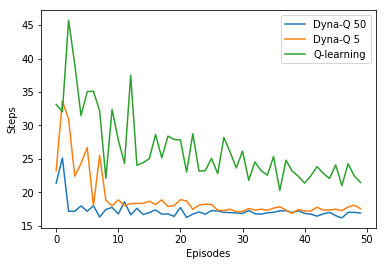

In [9]:
plt.plot(range(0,50),dyna50.tolist(), label = 'Dyna-Q 50')
plt.plot(range(0,50),dyna5.tolist(), label = 'Dyna-Q 5')
plt.plot(range(0,50),q.tolist(), label = 'Q-learning')
#plt.ylim((10,300))
plt.xlabel('Episodes')
plt.ylabel('Steps')
plt.legend()
plt.show()

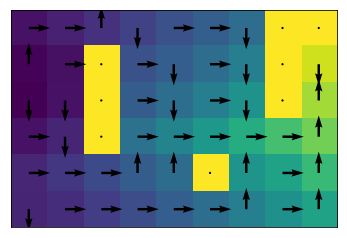

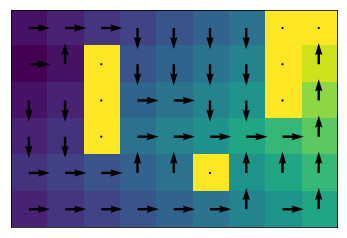

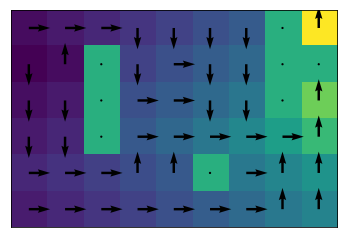

In [10]:
showQ(qAgent.Q_values)
showQ(dyna5Agent.Q_values)
showQ(dyna50Agent.Q_values)